In [2]:
import math
from typing import Tuple, List
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SinusoidalEmbeddings(nn.Module):
    """Transformer-style sinusoidal time embedding -> [B, D] vector."""
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        self.embed_dim = embed_dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        device = t.device
        half = self.embed_dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device) / max(half - 1, 1))
        arg = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(arg), torch.cos(arg)], dim=1)
        if self.embed_dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb  # [B, D]


In [4]:
class ResBlock(nn.Module):
    """
    GroupNorm + SiLU; 2x 3x3 convs; residual; 1x1 skip when channels change.
    Time vector projected (Linear) and added as bias after conv1.
    """
    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int, dropout_prob: float = 0.0):
        super().__init__()
        g1 = 32 if in_channels % 32 == 0 else 1
        g2 = 32 if out_channels % 32 == 0 else 1
        self.norm1 = nn.GroupNorm(g1, in_channels)
        self.act = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.time_proj = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, out_channels))  # persistent

        self.norm2 = nn.GroupNorm(g2, out_channels)
        self.dropout = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor, t_vec: torch.Tensor) -> torch.Tensor:
        h = self.act(self.norm1(x))
        h = self.conv1(h)
        h = h + self.time_proj(t_vec)[..., None, None]
        h = self.act(self.norm2(h))
        h = self.dropout(h)
        h = self.conv2(h)
        return h + self.skip(x)

In [5]:
class AttentionBlock(nn.Module):
    """Single-head spatial self-attention with GroupNorm pre-norm."""
    def __init__(self, channels: int, num_heads: int = 1):
        super().__init__()
        self.norm = nn.GroupNorm(32 if channels % 32 == 0 else 1, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)
        self.num_heads = num_heads

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        hd = C // self.num_heads
        q = q.view(B, self.num_heads, hd, H*W).transpose(2, 3)
        k = k.view(B, self.num_heads, hd, H*W)
        v = v.view(B, self.num_heads, hd, H*W).transpose(2, 3)
        attn = (q @ k) * (hd ** -0.5)
        attn = attn.softmax(dim=-1)
        out = attn @ v
        out = out.transpose(2, 3).contiguous().view(B, C, H, W)
        out = self.proj(out)
        return out + x


class Downsample(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1)
    def forward(self, x): return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        return self.conv(x)


In [6]:
class UNET(nn.Module):
    """
    DDPM-faithful U-Net for 32×32 (MNIST-friendly):
      - Resolutions: 32→16→8→4 (down) and back
      - Two ResBlocks per level
      - Self-attention at 16×16
      - Skip connections by concatenation
      - Time: sinusoid → MLP vector → per-block Linear bias
    """
    def __init__(
        self,
        Channels: list = None,
        input_channels: int = 1,
        output_channels: int = 1,
        time_steps: int = 1000,
        base_channels: int = 64,
        channel_mults: Tuple[int, ...] = (1, 2, 2, 2),  # 4 levels for 32×32
        num_res_blocks: int = 2,
        attn_resolutions: Tuple[int, ...] = (16,),
        image_size: int = 32,
        time_emb_dim: int = 128,
        dropout: float = 0.0,
        num_heads: int = 1,
    ):
        super().__init__()
        self.image_size = image_size
        self.attn_resolutions = set(attn_resolutions)

        # time path: sinusoid -> MLP
        self.pos_emb = SinusoidalEmbeddings(time_steps, time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )

        self.init_conv = nn.Conv2d(input_channels, base_channels, kernel_size=3, padding=1)

        # Plan skips (channels only)
        skip_channels: List[int] = []
        skip_channels.append(base_channels)  # after init_conv

        # Down path
        self.downs = nn.ModuleList()
        H = W = image_size
        now_ch = base_channels

        for i_level, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            for _ in range(num_res_blocks):
                self.downs.append(ResBlock(now_ch, out_ch, time_emb_dim, dropout))
                now_ch = out_ch
                skip_channels.append(now_ch)  # push after each ResBlock
                if H in self.attn_resolutions:
                    self.downs.append(AttentionBlock(now_ch, num_heads=num_heads))
            if i_level != len(channel_mults) - 1:
                self.downs.append(Downsample(now_ch, now_ch))
                H //= 2; W //= 2
                # no skip after downsample

        # Middle
        self.mid = nn.ModuleList([
            ResBlock(now_ch, now_ch, time_emb_dim, dropout),
            AttentionBlock(now_ch, num_heads=num_heads),
            ResBlock(now_ch, now_ch, time_emb_dim, dropout),
        ])

        # Up path
        self.ups = nn.ModuleList()
        plan_skips = skip_channels.copy()  # pop from this to set in_ch correctly

        for i_level, mult in reversed(list(enumerate(channel_mults))):
            out_ch = base_channels * mult
            blocks_here = num_res_blocks + (1 if i_level == 0 else 0)  # top level consumes initial skip
            for _ in range(blocks_here):
                skip_ch = plan_skips.pop()
                in_ch = now_ch + skip_ch
                self.ups.append(ResBlock(in_ch, out_ch, time_emb_dim, dropout))
                now_ch = out_ch
                if H in self.attn_resolutions:
                    self.ups.append(AttentionBlock(now_ch, num_heads=num_heads))
            if i_level != 0:
                self.ups.append(Upsample(now_ch, now_ch))
                H *= 2

        self.out_norm = nn.GroupNorm(32 if now_ch % 32 == 0 else 1, now_ch)
        self.out_act  = nn.SiLU()
        self.out_conv = nn.Conv2d(now_ch, output_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # time vector
        t_vec = self.pos_emb(t)
        t_vec = self.time_mlp(t_vec)

        # encoder
        h = self.init_conv(x)
        skips: List[torch.Tensor] = [h]  # initial skip

        for m in self.downs:
            if isinstance(m, ResBlock):
                h = m(h, t_vec); skips.append(h)
            elif isinstance(m, AttentionBlock):
                h = m(h)
            elif isinstance(m, Downsample):
                h = m(h)  # no skip push
            else:
                h = m(h)

        # bottleneck
        for m in self.mid:
            if isinstance(m, ResBlock):
                h = m(h, t_vec)
            else:
                h = m(h)

        # decoder (skip concat)
        for m in self.ups:
            if isinstance(m, ResBlock):
                skip = skips.pop()
                h = torch.cat([h, skip], dim=1)
                h = m(h, t_vec)
            elif isinstance(m, AttentionBlock):
                h = m(h)
            elif isinstance(m, Upsample):
                h = m(h)
            else:
                h = m(h)

        h = self.out_act(self.out_norm(h))
        return self.out_conv(h)

In [7]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps=1000):
        super().__init__()
        self.num_time_steps = num_time_steps
        beta = torch.linspace(1e-4, 0.02, num_time_steps, device=device)
        alpha = 1 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        self.register_buffer('beta', beta)
        self.register_buffer('alpha', alpha)
        self.register_buffer('alpha_bar', alpha_bar)

    def forward(self, t):
        return self.beta[t], self.alpha_bar[t]


@torch.no_grad()
def sample(model, scheduler, num_samples=16, num_time_steps=1000, image_size=32):
    """
    Reverse diffusion with fixed variance (sqrt(beta))
    Outputs are mapped from [-1,1] -> [0,1] for display.
    """
    model.eval()
    x = torch.randn(num_samples, 1, image_size, image_size, device=device)
    for t in tqdm(reversed(range(num_time_steps)), desc="Sampling"):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_tensor)
        beta, alpha_bar = scheduler(t_tensor)
        beta = beta.view(-1, 1, 1, 1)
        alpha_bar = alpha_bar.view(-1, 1, 1, 1)
        alpha = 1 - beta
        noise = torch.randn_like(x) if t > 0 else 0
        x = (1 / torch.sqrt(alpha)) * (x - ((beta / torch.sqrt(1 - alpha_bar)) * predicted_noise)) + torch.sqrt(beta) * noise

    # Convert from [-1,1] to [0,1] for visualization
    x = (x + 1) * 0.5
    return x.clamp(0, 1)

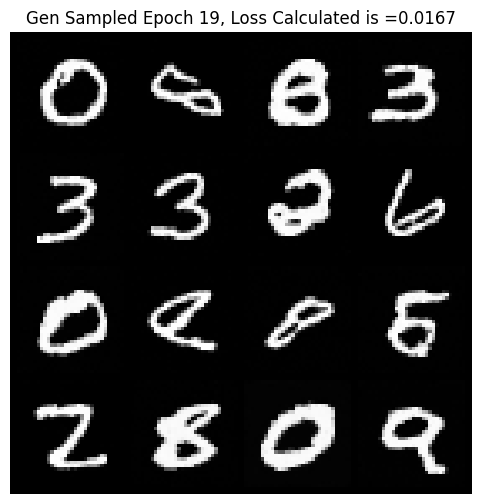

Sampling: 0it [00:00, ?it/s]

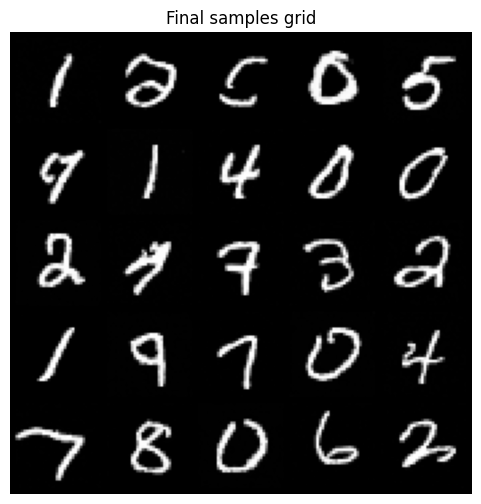

In [8]:
def train(batch_size=128, num_epochs=20, num_time_steps=1000, lr=2e-4, sample_every=10):
    # MNIST -> 32×32, normalized to [-1,1]
    train_dataset = datasets.MNIST(
        root='./data', train=True, download=True,
        transform=transforms.Compose([
            transforms.Pad(2),                 # 28 -> 32
            transforms.ToTensor(),             # [0,1]
            transforms.Normalize((0.5,), (0.5,))  # -> [-1,1]
        ])
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)

    model = UNET(input_channels=1, output_channels=1, time_steps=num_time_steps, base_channels=64, time_emb_dim=128).to(device)
    scheduler = DDPM_Scheduler(num_time_steps).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x0, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x0 = x0.to(device)                             # [-1,1], [B,1,32,32]
            B = x0.size(0)
            t = torch.randint(0, num_time_steps, (B,), device=device).long()
            noise = torch.randn_like(x0)

            _, alpha_bar = scheduler(t)
            alpha_bar = alpha_bar.view(B, 1, 1, 1)

            x_t = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise

            pred = model(x_t, t)
            loss = criterion(pred, noise)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")

        # sample periodically
        if ((epoch + 1) % sample_every == 0) or ((epoch + 1) == num_epochs):
            model.eval()
            with torch.no_grad():
                imgs = sample(model, scheduler, num_samples=16, num_time_steps=500, image_size=32)
                grid = vutils.make_grid(imgs, nrow=4)
                clear_output(wait=True)
                plt.figure(figsize=(6,6))
                plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
                plt.axis('off')
                plt.title(f'Gen Sampled Epoch {epoch+1}, Loss Calculated is ={avg_loss:.4f}')
                plt.show()
            model.train()

    return model, scheduler


if __name__ == "__main__":
    model, sched = train(batch_size=128, num_epochs=19, num_time_steps=1000, lr=2e-4, sample_every=10)

    # Final sample grid
    with torch.no_grad():
        imgs = sample(model, sched, num_samples=25, num_time_steps=1000, image_size=32)
        grid = vutils.make_grid(imgs, nrow=5)
        plt.figure(figsize=(6,6))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Final samples grid')
        plt.show()